# **Random Forest model training**

## **Import libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import os

## **Split to train and test data**

## **Read & Process data**

In [3]:
# Load the second CSV file with the first column as the index
combined_df = pd.read_csv('./Dataset/tsfresh_features.csv', index_col=0)
# combined_df.index = combined_df['Unnamed: 0']
combined_df = combined_df.sort_index()
comparison_file_path = './Dataset/q1_q17_dr25_koi.csv'
comparison_df = pd.read_csv(comparison_file_path, index_col=1)

# Restrict to the first 900 rows of the second CSV
comparison_df = comparison_df.iloc[:2000]

# Find the missing indices
missing_indices = comparison_df.index.difference(combined_df.index)

# Display the missing indices
if missing_indices.empty:
    print("No missing indices found.")
else:
  print("Missing indices:")
  print(missing_indices)

# print(combined_df.index)

Missing indices:
Index(['K00787.01', 'K00787.02', 'K00787.03', 'K00930.01', 'K00961.01',
       'K00961.02', 'K00961.03', 'K00966.01', 'K01000.01', 'K01013.01',
       ...
       'K01515.02', 'K01516.01', 'K01517.01', 'K01518.01', 'K01519.01',
       'K01519.02', 'K01520.01', 'K01521.01', 'K01522.01', 'K01522.02'],
      dtype='object', length=134)


In [4]:
# Calculating koi_disposition column
comparison_file_path = './Dataset/q1_q17_dr25_koi.csv'
comparison_df = pd.read_csv(comparison_file_path, index_col=1)
comparison_df2 = comparison_df[1600:2000]
value_counts = comparison_df2['koi_disposition'].value_counts()

# Show how many CONFIRMED and Others
confirmed_count = value_counts.get('CONFIRMED', 0)
other_count = value_counts.sum() - confirmed_count

print(f"CONFIRMED : {confirmed_count}")
print(f"Others    : {other_count}")
# print(comparison_df2[0:1])


CONFIRMED : 218
Others    : 182


In [5]:
# Check for duplicate indices in combined_df
combined_df = combined_df.loc[~combined_df.index.duplicated(keep='first')]
duplicate_indices_combined = combined_df.index[combined_df.index.duplicated(keep=False)]

if not duplicate_indices_combined.empty:
    print("Duplicate indices found in combined_df:")
    print(duplicate_indices_combined)
else:
    print("No duplicate indices found in combined_df.")

No duplicate indices found in combined_df.


In [6]:
# Fill all the nan value with 0
combined_df = combined_df.fillna(0)

# Find rows and columns with NaN values
nan_rows_cols = combined_df[combined_df.isna().any(axis=1)]

if not nan_rows_cols.empty:
    print("Rows and columns with NaN values:")
    for index, row in nan_rows_cols.iterrows():
        nan_cols = row.index[row.isna()]
        print(f"Row index: {index}, Columns with NaN: {list(nan_cols)}")
else:
    print("No NaN values found in the DataFrame.")

No NaN values found in the DataFrame.


In [7]:
# Identify columns with all the same values or entirely NaN
same_value_columns = []
same_value_data = {}  # Dictionary to store the value each same column holds
nan_columns = []

# Check for columns with a single unique value
for col in combined_df.columns:
    if combined_df[col].nunique(dropna=True) == 1:  # Only one unique value (ignoring NaNs)
        # Store the unique value for columns with the same value
        unique_value = combined_df[col].dropna().iloc[0]  # Get the non-NaN value
        same_value_columns.append(col)
        same_value_data[col] = unique_value

# Check for columns with all NaN values
nan_columns = combined_df.columns[combined_df.isna().all()].tolist()

# Print out the results
print("Columns with the same value:")
for col in same_value_columns:
    print(f"{col}: {same_value_data[col]}")

print("\nColumns with all NaN values:")
print(nan_columns)

# Combine columns to drop
columns_to_drop = list(set(same_value_columns + nan_columns))

# Remove duplicates in case of overlap
columns_to_drop = list(set(columns_to_drop))

# List the columns to drop
print("Columns to drop:", columns_to_drop)

Columns with the same value:
light_curve__variance_larger_than_standard_deviation: 0.0
light_curve__has_duplicate_max: 0.0
light_curve__has_duplicate_min: 0.0
light_curve__has_duplicate: 0.0
light_curve__percentage_of_reoccurring_values_to_all_values: 0.0
light_curve__percentage_of_reoccurring_datapoints_to_all_datapoints: 0.0
light_curve__sum_of_reoccurring_values: 0.0
light_curve__sum_of_reoccurring_data_points: 0.0
light_curve__ratio_value_number_to_time_series_length: 1.0
light_curve__symmetry_looking__r_0.0: 0.0
light_curve__symmetry_looking__r_0.2: 1.0
light_curve__symmetry_looking__r_0.25: 1.0
light_curve__symmetry_looking__r_0.30000000000000004: 1.0
light_curve__symmetry_looking__r_0.35000000000000003: 1.0
light_curve__symmetry_looking__r_0.4: 1.0
light_curve__symmetry_looking__r_0.45: 1.0
light_curve__symmetry_looking__r_0.5: 1.0
light_curve__symmetry_looking__r_0.55: 1.0
light_curve__symmetry_looking__r_0.6000000000000001: 1.0
light_curve__symmetry_looking__r_0.65: 1.0
light_

In [8]:
koi_features = combined_df.drop(columns=columns_to_drop)

In [9]:
inf_columns = koi_features.columns[(koi_features == float('inf')).any() | (koi_features == float('-inf')).any()]

# Loop through each column with inf values and display the indices
for col in inf_columns:
    # Get the indices of rows where the column has inf values
    inf_indices = koi_features[koi_features[col].isin([float('inf'), float('-inf')])].index
    print(f"Indices with inf values in column '{col}':")
    print(inf_indices)

In [10]:
# Drop rows where any column has inf values
koi_features = koi_features[~koi_features.isin([float('inf'), float('-inf')]).any(axis=1)]
print("Shape of the cleaned data:", koi_features.shape)

Shape of the cleaned data: (1866, 739)


In [11]:
# Find rows and columns with NaN values
nan_rows_cols = koi_features[koi_features.isna().any(axis=1)]

if not nan_rows_cols.empty:
    print("Rows and columns with NaN values:")
    for index, row in nan_rows_cols.iterrows():
        nan_cols = row.index[row.isna()]
        print(f"Row index: {index}, Columns with NaN: {list(nan_cols)}")
else:
    print("No NaN values found in the DataFrame.")

No NaN values found in the DataFrame.


In [12]:
pca_data = koi_features
# Extract the 'label' column as the target for training
koi_labels = koi_features.pop('label')
# Show the distribution of Label
koi_labels.value_counts()

label
1    1216
0     650
Name: count, dtype: int64

## **Split train test**

In [13]:
train_features = koi_features.loc[:'K01126.01']
train_labels = koi_labels.loc[:'K01126.01']

test_features = koi_features.loc['K01126.02':]
test_labels = koi_labels.loc['K01126.02':]

In [14]:

# Show the distribution of Label
test_labels.value_counts()

label
1    187
0    182
Name: count, dtype: int64

In [15]:
x_train, y_train, = train_features[:1300],train_labels[:1300]
x_val , y_val = train_features[1301:],train_labels[1301:]
x_test, y_test = test_features,test_labels
print(len(x_train),len(x_val),len(x_test))

1300 196 369


# **Finding the best parameters**

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Try to get your best parameters by changing or adding some "grid" below
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 5,7,9],
    'min_samples_leaf': [1, 2,3,4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Check best parameters
print(f"Best parameters: {grid_search.best_params_}")

/opt/miniconda3/envs/nthu_ml/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [18]:
max_depth = grid_search.best_params_['max_depth']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']
min_samples_split = grid_search.best_params_['min_samples_split']
print(f'{max_depth=}\n{min_samples_leaf=}\n{min_samples_split=}')

max_depth=8
min_samples_leaf=1
min_samples_split=2


In [20]:
train_accuracy = []
val_accuracy = []
train_f1 = []
val_f1 = []

# Change the range to test more epochs
for n_estimators in range(1, 100):
    clf = RandomForestClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_estimators=n_estimators,random_state=39)
    clf.fit(x_train, y_train)
    
    # Evaluating
    train_accuracy.append(metrics.accuracy_score(y_train, clf.predict(x_train)))
    val_accuracy.append(metrics.accuracy_score(y_val, clf.predict(x_val)))
    train_f1.append(metrics.f1_score(y_train, clf.predict(x_train)))
    val_f1.append(metrics.f1_score(y_val, clf.predict(x_val)))


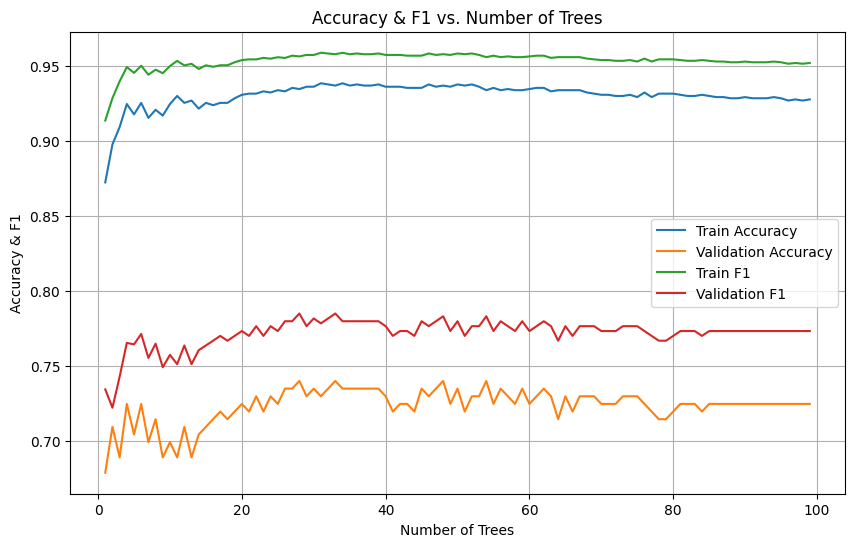

In [21]:
# Ploting accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), train_accuracy, label='Train Accuracy')
plt.plot(range(1, 100), val_accuracy, label='Validation Accuracy')
plt.plot(range(1, 100), train_f1, label='Train F1')
plt.plot(range(1, 100), val_f1, label='Validation F1')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy & F1')
plt.title('Accuracy & F1 vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Getting best epochs
m = max(val_f1)
best_epoch = 0
print(m)
for i in range(len(val_f1)):
    if val_f1[i]==m:
        best_epoch = i+1
print(f'{best_epoch=}')

0.7848101265822784
best_epoch=33


accuracy=0.74
precision=0.66
recall=0.97
f1=0.78


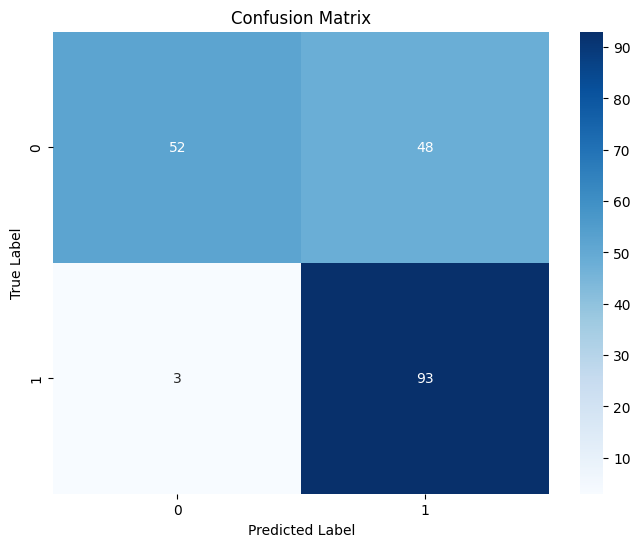

In [23]:
clf = RandomForestClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_estimators=best_epoch,random_state=39)
clf.fit(x_train,y_train)

y_pred_val = clf.predict(x_val)

precision = metrics.precision_score(y_val,y_pred_val)#,average='micro')
recall = metrics.recall_score(y_val,y_pred_val)#,average='micro')
accuracy = metrics.accuracy_score(y_val,y_pred_val)
f1 = metrics.f1_score(y_val,y_pred_val)#,average='micro')
print(f'{accuracy=:.2f}\n{precision=:.2f}\n{recall=:.2f}\n{f1=:.2f}')

cm = metrics.confusion_matrix(y_val, y_pred_val)

# Plotting confusion matrics
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

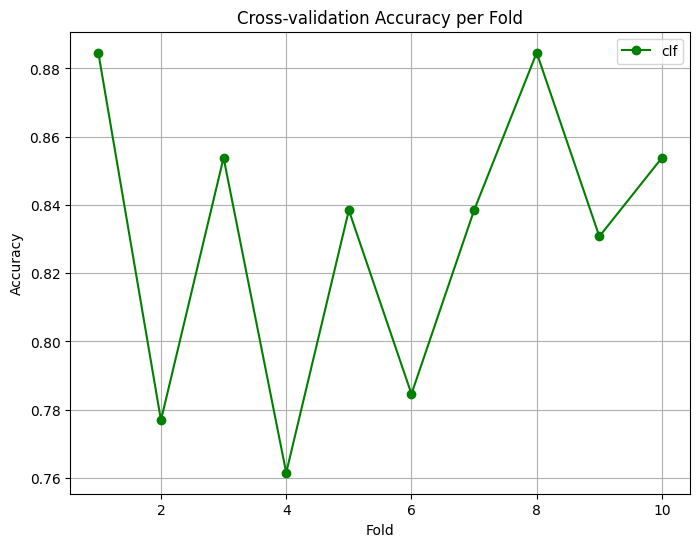

In [24]:
from sklearn.model_selection import cross_val_score

# Calculate cross validation score
cv_scores = cross_val_score(clf, x_train, y_train, cv=10)

# Plot cross validation scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', color='g', label='clf')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-validation Accuracy per Fold')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
feature_importance = clf.feature_importances_

# Save features' name into feature_names
feature_names = x_train.columns[:].tolist()

# Combine feature names with their importance scores
feature_importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Sort the features by importance (descending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the sorted features
print("Sorted Feature Importance:")
for feature, score in sorted_features[:50]:  # Top 50 features
    print(f"{feature}: {score}")


Sorted Feature Importance:
light_curve__fft_coefficient__attr_"abs"__coeff_4: 0.01992520072158496
light_curve__standard_deviation: 0.018836456048063728
light_curve__mean_n_absolute_max__number_of_maxima_7: 0.017432211463669488
light_curve__permutation_entropy__dimension_3__tau_1: 0.016868248090003785
light_curve__quantile__q_0.1: 0.01626722848901833
light_curve__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0: 0.014850496182380778
light_curve__ar_coefficient__coeff_2__k_10: 0.01425663810621226
light_curve__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min": 0.013251814739998185
light_curve__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min": 0.01228391137273325
light_curve__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min": 0.011707431750326675
light_curve__minimum: 0.011352368370407923
light_curve__energy_ratio_by_chunks__num_segments_10__segment_focus_5: 0.010008298094573409
light_curve__ratio_beyond_r_sigma__r_3: 0.009810332695564744
light_c

# **Try to get yours**

accuracy=0.76
precision=0.69
recall=0.94
f1=0.80


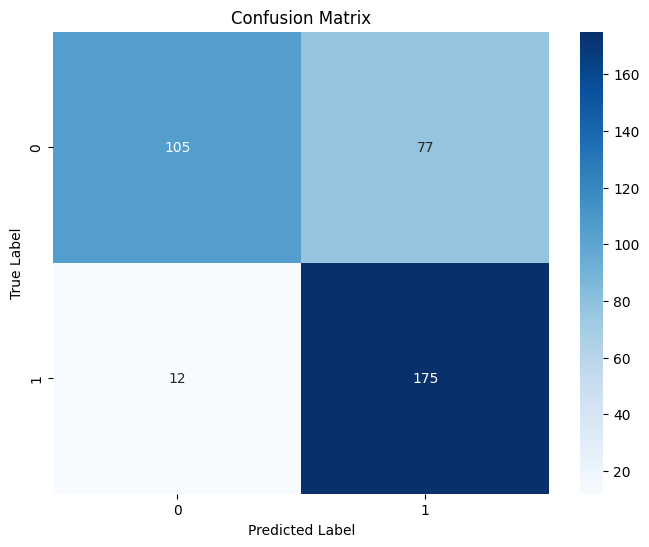

In [27]:
### Start code here
# clf = RandomForestClassifier(max_depth=None,min_samples_leaf=None,min_samples_split=None,n_estimators=None,random_state=39)
# clf.fit(None,None)
### End code here
y_pred_test = clf.predict(x_test)

precision = metrics.precision_score(y_test,y_pred_test)#,average='micro')
recall = metrics.recall_score(y_test,y_pred_test)#,average='micro')
accuracy = metrics.accuracy_score(y_test,y_pred_test)
f1 = metrics.f1_score(y_test,y_pred_test)#,average='micro')
print(f'{accuracy=:.2f}\n{precision=:.2f}\n{recall=:.2f}\n{f1=:.2f}')

cm = metrics.confusion_matrix(y_test, y_pred_test)

# Plotting confusion matrics
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()